In [1]:
import bisect
import itertools as it
import random

import numpy as np
from hmmlearn import hmm

In [4]:
NUCLEOTIDES = "ACGT"
DINUCLEOTIDES = list(it.starmap("{}{}".format, it.product(NUCLEOTIDES, NUCLEOTIDES)))

def dinucleotide_to_num(seq):
    lookup = dict(zip(DINUCLEOTIDES, range(len(NUCLEOTIDES) ** 2)))
    
    odd_bases = seq[::2]
    even_bases = seq[1::2]
    
    dinucleotides = it.starmap("{}{}".format, zip(odd_bases, even_bases))
    
    return [lookup[di] for di in dinucleotides]


class Model:
    def __init__(self, cpg_to_cpg, normal_to_normal, cpg_to_normal, normal_to_cpg, alphabet=NUCLEOTIDES):        
        self.cpg_to_cpg = cpg_to_cpg
        self.normal_to_normal = normal_to_normal
        self.cpg_to_normal = cpg_to_normal
        self.normal_to_cpg = normal_to_cpg
        self.alphabet = alphabet    

    def _cgp_probs(self):
        joint = np.concatenate(
            (
                (1 - self.cpg_to_normal) * self.cpg_to_cpg,
                self.cpg_to_normal * self.normal_to_normal,
            ),
            axis=1,
        )

        return joint

    def _normal_probs(self):
        joint = np.concatenate(
            (
                self.normal_to_cpg * self.cpg_to_cpg,
                (1 - self.normal_to_cpg) * self.normal_to_normal,
            ),
            axis=1,
        )

        return joint

    def transition_probs(self):
        return np.concatenate((self._cgp_probs(), self._normal_probs()))

    def generate(self, length):        
        transition_cumsum = self.transition_probs().cumsum(axis=1)
        bases = []
        cpg_sites = []
        cpg_start = None
        in_cpg = False

        start = random.randrange(len(transition_cumsum))
        bases.append(self.alphabet[start % len(self.alphabet)])

        if start < 4:
            in_cpg = True
            cpg_start = start

        prev_index = start
        for i in range(1, length):
            p = random.random()
            next_index = bisect.bisect_left(transition_cumsum[prev_index], p)
            bases.append(self.alphabet[next_index % len(self.alphabet)])

            if next_index < 4:
                if not in_cpg:
                    cpg_start = i
                    in_cpg = True
            else:
                if in_cpg:
                    cpg_sites.append((cpg_start, i - 1))
                    in_cpg = False

            prev_index = next_index

        if in_cpg:
            cpg_sites.append((cpg_start, length - 1))

        return "".join(bases), cpg_sites

In [5]:
# Rows are ACGT, columns are ACGT
cpg_to_cpg_probs = np.array(
    [
        [0.1, 0.4, 0.4, 0.1],
        [0.05, 0.45, 0.45, 0.05],
        [0.05, 0.45, 0.45, 0.05],
        [0.1, 0.4, 0.4, 0.1],
    ]
)

normal_to_normal_probs = np.array(
    [
        [0.25, 0.25, 0.25, 0.25],
        [0.15, 0.35, 0.35, 0.15],
        [0.15, 0.35, 0.35, 0.15],
        [0.25, 0.25, 0.25, 0.25],
    ]
)

cpg_to_normal_prob = 0.005
normal_to_cpg_prob = 0.0025

simulator = Model(cpg_to_cpg_probs, normal_to_normal_probs, cpg_to_normal_prob, normal_to_cpg_prob)
seq_train, cpg_train = simulator.generate(1000)
seq_test, cpg_test = simulator.generate(500)

In [7]:
dinuc = np.array(dinucleotide_to_num(seq_train)).reshape(1,-1)

In [8]:
initial_emission_matrix = np.array(
    [[0.95, 0.05],
     [0.05, 0.95]]
)

model = hmm.MultinomialHMM(n_components=2, transmat_prior=initial_emission_matrix, 
                           n_iter=50, verbose=True)
model.fit(dinuc)

         1       -1400.7734             +nan
         2       -1296.6302        +104.1432
         3       -1296.4561          +0.1741
         4       -1296.2784          +0.1776
         5       -1296.0852          +0.1932
         6       -1295.8713          +0.2139
         7       -1295.6392          +0.2321
         8       -1295.3957          +0.2435
         9       -1295.1464          +0.2493
        10       -1294.8941          +0.2524
        11       -1294.6398          +0.2542
        12       -1294.3854          +0.2545
        13       -1294.1334          +0.2520
        14       -1293.8870          +0.2464
        15       -1293.6490          +0.2380
        16       -1293.4215          +0.2275
        17       -1293.2055          +0.2160
        18       -1293.0012          +0.2044
        19       -1292.8077          +0.1934
        20       -1292.6242          +0.1835
        21       -1292.4494          +0.1748
        22       -1292.2820          +0.1674
        23

MultinomialHMM(n_components=2, n_iter=50,
               random_state=RandomState(MT19937) at 0x7F2B5C99B940,
               transmat_prior=array([[0.95, 0.05],
       [0.05, 0.95]]),
               verbose=True)

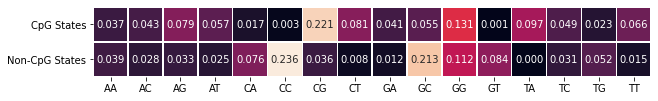

In [29]:
def plot_emmision_probabilities(probs, dinuc):
    import seaborn as sns
    from matplotlib import pyplot as plt
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(probs, square=True, yticklabels=['CpG States', 'Non-CpG States'], 
                     xticklabels=dinuc, annot=True, 
                     linewidths=0.5, ax=ax, cbar=False, fmt='.3f')
    
plot_emmision_probabilities(model.emissionprob_, DINUCLEOTIDES)

The emission probability matrix of symbols given hidden state has a clear biological interpretation: when we're currently in a CpG island, the probability of emitting a CG dinucleotyde is significantly higher than outside CG island.

In [30]:
dinuc = np.array(dinucleotide_to_num(seq_test)).reshape(1,-1).T
print(model.predict(dinuc))
print(cpg_test)
print(seq_test)

[0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1
 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0]
[(1, 238)]
CGGGCGCGGGCAACCCCGCGTCCGCGCAGGGGCCCACCCGCCCCGGCCGGCGGCCCCGGGCCCACGGCCGCGGGCCCGCCCCGGCGGGTTTCCGATCGGGCGCCCGGCGGCCCCGCACGCTGCTGCCGGCCGCGGCCCGGGGCGGCGGGGGGGGGCTCGCGGCCAGGGCGGGCCCCCGCCCCCGCGGGGCAGCGCCCGCCGGCGGCCCGGCCCAGGCTGCGCCGGCGCATGCCGCGGGGATGGACCCAAAAACGTGTCTGGCTAAGGGGGTCGGGCTAATATACCGCGAAGCGATATATTCTATAGCCTTGAGGCCCCCCGTTCGCAACGGCCTGTGCGGCAGGGATGAATGGACTAATTTCGCCACGGGTGGCGCCTAGGGGGAAAGGTCATAGCCGGCTGCACCGATGCTCGCGCCAGGCGGCTCTAACCCAGGAGAAAACCTCCCATGAATAGAATCCGCGGCTGCGTGCACCATTTC